# Black-hole binary formation channels with gaussian mixtures

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset.

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.

Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057).

![ZevinPlot.png](ZevinPlot.png)

where they consider 5 possibilities for the formation of black hole binaries: common envelope (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT).

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).

Anyway. You can find today's dataset at `solutions/formationchannels.npy`.

*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

Some events form in different astrophysical environments than others. You want to figure out how many of formation channels are at play.

The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of N gaussians each with mean $\mu_i$ and standard deviation $\sigma_i$ and weight $\alpha_i$:
                
$$p(x_i|\theta) = \sum_{j=1}^N \alpha_j N(\mu_j, \sigma_j)$$

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_i$ must be unity to ensure that this is a probability)

**Tasks**
- Load this file (np.load) and complete a quick exploration of the data. How many modes do you think you see?

- We'll use sklearn.mixture.GaussianMixture. You first need to define the model (instance of a class), and then train it on the data using the fit method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

Note: We'll do a more formal introduction to scikit-learn in one of the next lectures. Today's exercise is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens all the time in research...

- Complete the fit 10 times with $N = 1, ..., 10$ Gaussians.

Note: sklearn by default will use the so-called Expectation-Maximization algorithm, which is one of the many great things in data science we don't have time to study in this class.

- For each of these fits, compute the AIC (easy! It's an attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

- Plot the preferred solution on top of the input data. You should get a very nice fit!

- Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset.

Hint: Useful methods here are score_samples and predict_proba.

In [130]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from sklearn.mixture import GaussianMixture as skGaussianMix

In [131]:
# Import data
data = np.load("formationchannels.npy")

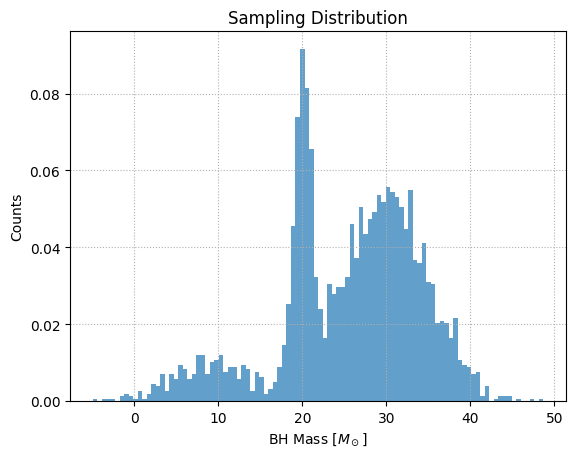

In [132]:
# Sampling distribution
plt.hist(data, bins=100, density=True, alpha=0.7)
plt.title("Sampling Distribution")
plt.xlabel("BH Mass $[M_\odot]$")
plt.ylabel("Counts")
plt.grid(linestyle=':')
plt.show()

Hypotesis: the sampling distribution presents 3 Gaussian distribution.

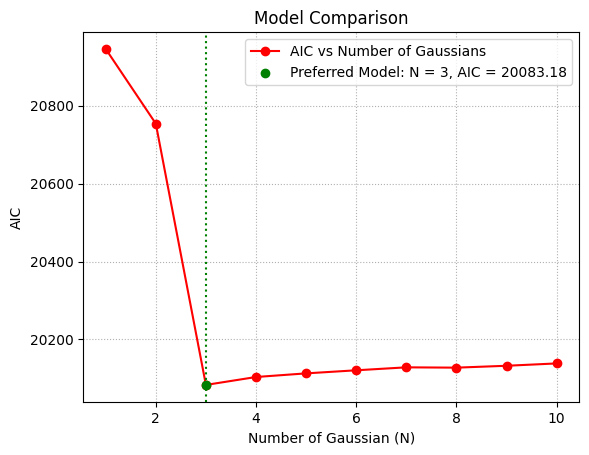

In [133]:
# Complete the fit 10 times with N = 1, ..., 10
N = 10
n_components = np.arange(1, N+1)
AIC = np.array([])

for n in n_components:
    model = skGaussianMix(n)
    model.fit(data)
    AIC = np.append(AIC, model.aic(data))

best_n = n_components[np.argmin(AIC)]
best_AIC = np.min(AIC)

plt.plot(n_components, AIC, marker='o', color='red', linestyle='-',  label="AIC vs Number of Gaussians")
plt.scatter(best_n, best_AIC, color='g', zorder=2, label=f'Preferred Model: N = {best_n}, AIC = {best_AIC:.2f}')
plt.axvline(best_n, linestyle=':', color='g')
plt.title("Model Comparison")
plt.xlabel("Number of Gaussian (N)")
plt.ylabel("AIC")
plt.legend()
plt.grid(linestyle=':')
plt.show()

My hypotesis was correct: the sampling distribution presents 3 Gaussian.

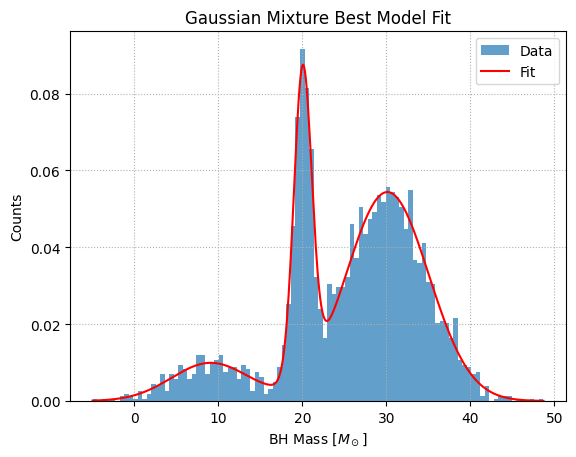

In [134]:
# Plot the solution with 3 Gaussian distibution
x = np.linspace(min(data), max(data), 500).reshape(-1, 1)

best_model = skGaussianMix(n_components=best_n)
best_model.fit(data)
pdf = np.exp(best_model.score_samples(x))

# Plot
plt.hist(data, bins=100, density=True, alpha=0.7, label='Data')
plt.plot(x, pdf, color='red', label='Fit')
plt.title("Gaussian Mixture Best Model Fit")
plt.xlabel("BH Mass $[M_\odot]$")
plt.ylabel("Counts")
plt.legend()
plt.grid(linestyle=':')
plt.show()

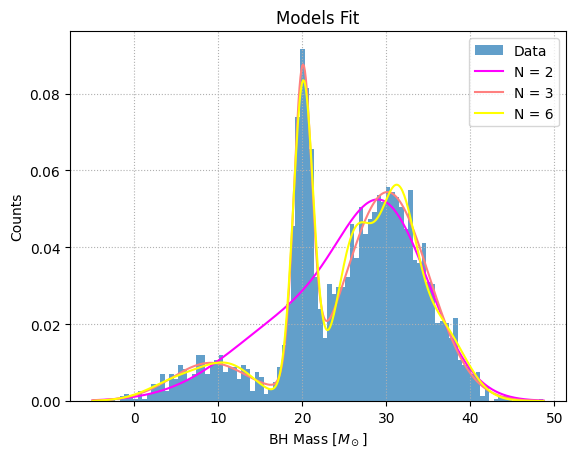

In [135]:
# Comparison with other model
models=[skGaussianMix(n).fit(data) for n in n_components]

plt.hist(data, bins=100, density=True, alpha=0.7, label='Data')

colors = plt.cm.spring(np.linspace(0, 1, 3))
for index, c in zip(np.array([1, 2, 5]), colors):
    pdfs = np.exp(models[index].score_samples(x))
    plt.plot(x, pdfs, color=c, label=f'N = {n_components[index]}')

plt.title("Models Fit")
plt.xlabel("BH Mass $[M_\odot]$")
plt.ylabel("Counts")
plt.legend()
plt.grid(linestyle = ":")
plt.show()

$N = 2$ is clearly a bad fit, while $N = 6$ looks better than $N = 3$ but the improvement is really enough to justify extra parametrs $-$ Occam's razor still wins.

## [Optional tasks, not examinable] Class labels or "responsibilities"

Class labels are a very interesting by product of a mixture analysis. What is the probability that a given gravitational-wave event comes from a given channel? This is called "responsiblity" (i.e. which mode is most likely to be responsible for that piece of data).

$$p(j | x_i) = \frac{a_j \mathcal{N}(\mu_j, \sigma_j)}{\sum_{j = 1}^N \alpha_j \mathcal{N}(\mu_j, \sigma_j)}$$

- [**Optional**] Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset.
Hint: Useful methods here are score_samples and predict_proba.

- [**Optional**] Derive the expression above using Bayes' rule (pen and paper!)

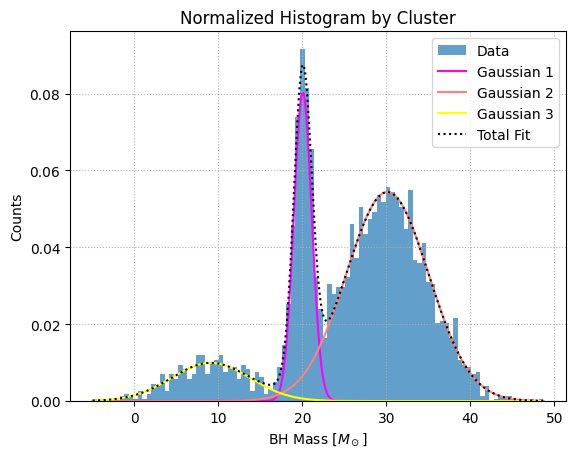

In [136]:
# Calculate the probability of each x point to a specific gaussian
responsibilities = best_model.predict_proba(x)

plt.hist(data, bins=100, density=True, alpha=0.7, label='Data')

colors = plt.cm.spring(np.linspace(0, 1, best_n))
for i in range(best_n):
    gaussian = responsibilities[:, i] * pdf
    plt.plot(x, gaussian, color=colors[i], label=f'Gaussian {i+1}')

plt.plot(x, pdf, linestyle=':', color='k', label='Total Fit')

plt.title("Normalized Histogram by Cluster")
plt.xlabel("BH Mass $[M_\odot]$")
plt.ylabel("Counts")
plt.legend()
plt.grid(linestyle=':')
plt.show()